# Optical Flow

In [1]:
%matplotlib notebook

import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
from skimage import io

VIDEO="data/hearth.mp4"
MASK="data/mask.png"
N_FEATURES = 20
COLORS = np.random.randint(0, 255,(N_FEATURES, 3))

# Feature detector parameters
F_PARAMS = {
    'maxCorners': N_FEATURES,
    'qualityLevel': 0.05,
    'minDistance': 7,
    'blockSize': 7
}

# Lucas-Kanade parameters
LK_PARAMS = {
    'winSize':(15,15),
    'maxLevel': 2,
    'criteria': (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 0.03)
}

### Extracting frames from a video

In order to use the video analysis methods, we will need to extract their frames in pairs.


In [2]:
to_grayscale = lambda i: cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)  

def video_frames(path):
    """
        Grabs the video frames into a generator
    """
    video = cv2.VideoCapture(path)
    
    while True:
        ok, frame = video.read()
        if not ok:
            break
        
        yield frame
    
    video.release()
            
def grab_frame_pair(path, idx, step=1):
    """
        Grabs video frames at index idx and idx+step, with first frame being 1.
    """
    frame_gen = video_frames(path)
    for i, frame in enumerate(frame_gen,1):
        if idx == i:
            break
    
    f1 = frame
    
    for i, frame in enumerate(frame_gen,1):
        if step == i:
            break
    
    f2 = frame
    
    return f1,f2
        

### Detection of characteristic points

<IPython.core.display.Javascript object>


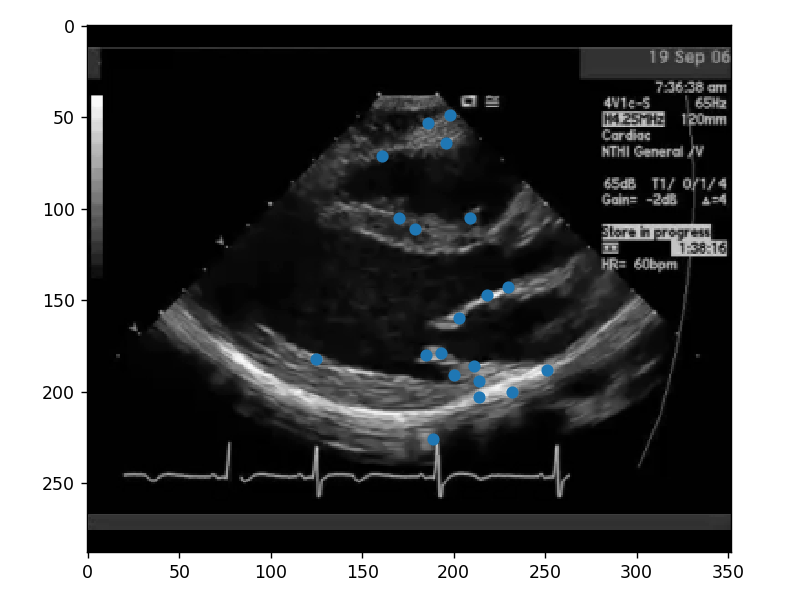

In [3]:
# read the mask
mask = cv2.cvtColor(cv2.imread(MASK),cv2.COLOR_RGB2GRAY)

# Grab 2 first frames
f1, f2 = grab_frame_pair(VIDEO, 1)
f1 = to_grayscale(f1)
f2 = to_grayscale(f2)

# Compute the features
p1 = cv2.goodFeaturesToTrack(f1, mask=mask, **F_PARAMS)

# Plot the feature locations
plt.figure()
io.imshow(f1)
h1=plt.scatter(p1[...,0],p1[...,1])


Now we apply the Lucas-Kanade algorithm on these characteristic points $ p_1 = (x_1, y_1) $ to calculate the optical flux between the first and second frames. The algorithm implemented in OpenCV returns the estimated positions $ p_2 = (x_2, y_2) $ of the points in the second frame, so we will have to do a subtraction to obtain the motion vectors V = $ (u, v) $ .

<IPython.core.display.Javascript object>


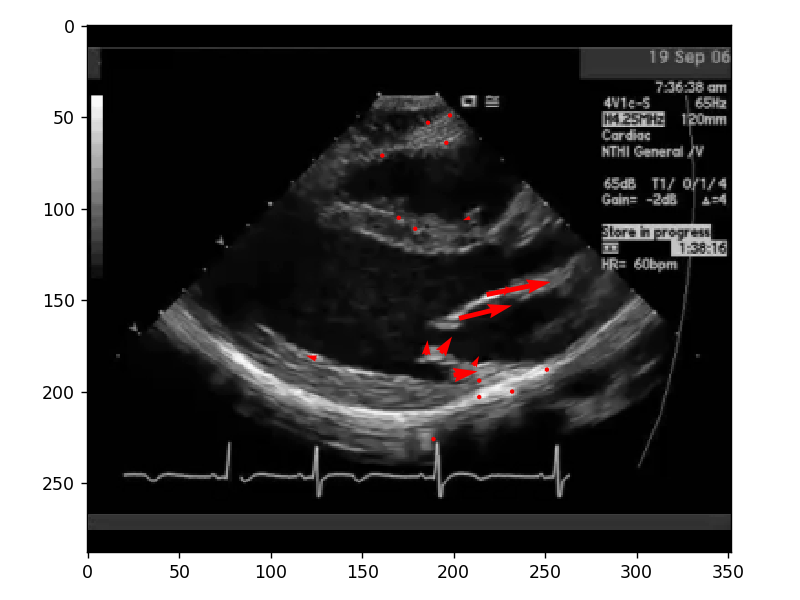

In [4]:
# Compute optical flow
p2, st, err = cv2.calcOpticalFlowPyrLK(f1, f2, p1, None, **LK_PARAMS) 

# Original point coordinates p1=(x1,y1)
x1 = p1[...,0]
y1 = p1[...,1]

# Current point coordinates p2=(x2,y2)
x2 = p2[...,0]
y2 = p2[...,1]

# Movement vectors V=(u,v), so that p2 = p1+V
u = x2-x1
v = y2-y1

# Arrow representation of vectors
plt.figure()
io.imshow(f1)
scale = 2
h2 = plt.quiver(x1, y1, u*scale, v*scale, angles='xy', scale_units='xy', scale=1, color='red')
    

### Visualization of Optical Flow in animations

In [5]:
def compute_LK_OF(frame_gen, points, params=LK_PARAMS):
    """
    Computes Lukas-Kanade Optical Flow from the generated frames at the given points
    
    Parameters
        * frame_gen is a python generator of images
        * points is a Nx2 or Nx1x2 list of N points in the image
        * params is a dict of additional parameters for the OpenCV Lucas-Kanade algorithm
    
    Returns a tuple (frame, points, vectors, st), where:
        * frame is an image
        * points is a Nx2 array of (x,y) locations at the frame
        * vectors is a Nx2 array of (u,v) velocity vectors from the previous frame
        * st is a Nx1 array of 0/1 values, that indicates the tracking status of each point
    """

    frame = next(frame_gen)
    f1 = to_grayscale(frame)
    p1 = points.reshape(-1,1,2).astype(dtype='float32') # OpenCV requires a Nx1x2 array of float32

    for frame in frame_gen:
        f2 = to_grayscale(frame)

        # calculate optical flow
        p2, st, err = cv2.calcOpticalFlowPyrLK(f1, f2, p1, None, **params)
        
        yield (frame, p2.reshape(-1,2), (p2-p1).reshape(-1,2), st.ravel())
        
        f1 = f2.copy()
        p1 = p2.reshape(-1, 1, 2)

def visualize_OF_paths(of_gen, colors = COLORS):
    """
    Draw optical flow paths
    """
    first_it = True
    for frame, p2, v, st in of_gen:
        if first_it:
            lines = np.zeros_like(frame)
            p1 = p2-v
            first_it = False
        
        # select good points (st = 1 if tracking is successed)
        p2_tracked = p2[st==1,:]
        p1_tracked = p1[st==1,:]
        
        # draw lines
        for i,(curr, prev) in enumerate(zip(p1_tracked, p2_tracked)):
            x1, y1 = curr.ravel()
            x0, y0 = prev.ravel()
            lines = cv2.line(lines, (x1, y1), (x0, y0), colors[i].tolist(), 1)
            frame = cv2.circle(frame, (x1, y1), 3, colors[i].tolist(), -1)
        
        # Prepare visualization for current frame
        visualization = cv2.add(frame, lines)
        visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)  # OpenCV has color BGR
        yield visualization
        
        # Upgrade points for next iteration
        p1 = p2
                
def draw_animation(vis_gen):
    """
    Animate an image generator
    """
    fig = plt.figure()
    ims = []

    for f in vis_gen:
        ims.append([io.imshow(f, animated=True)])

    ani = animation.ArtistAnimation(fig, ims)
    plt.axis("off")
    plt.show()
    return ani


Play animation

<IPython.core.display.Javascript object>


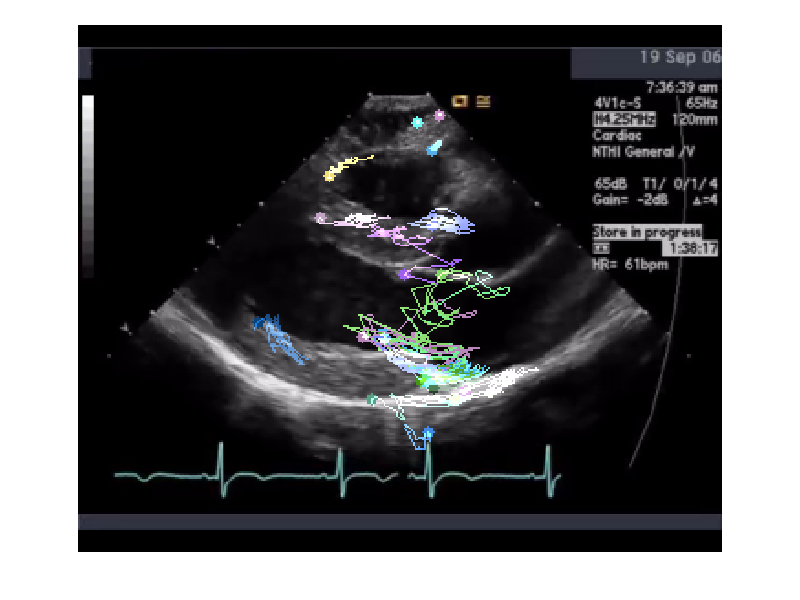

In [6]:
ani = draw_animation(visualize_OF_paths(compute_LK_OF(video_frames(VIDEO), p1)))